<a href="https://colab.research.google.com/github/EmilEdvardsson/10oct-22apr/blob/main/Copy_of_Miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import packages and read the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
#pip install pandas, matplotlib, sklearn, imblearn#

np.random.seed(1)

url = 'https://raw.githubusercontent.com/EmilEdvardsson/MyFiles/main/train.csv?token=GHSAT0AAAAAABSDIJORUHV35XB7OW74XLXYYRIZEEA'
data = pd.read_csv(url, na_values='?', dtype={'ID': str}).dropna().reset_index(drop = True)



# Process data:



In [ ]:
X = data.drop(columns=['Lead'])
y = data['Lead']

#ONE HOT ENCODING#
data = data.replace(['Male','Female'] ,[0 ,1])
y = data['Lead']

#SPLIT DATA INTO TRAINING AND TEST SETS#
X_train, X_test, y_train, y_test = skl_ms.train_test_split(X, y, random_state=45)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

with_outliers = len(X_train)

#NORMALIZE DATA ALL FEATURES# 
#(Split before standardization to avoid data leakage)
names = X_train.columns

##TEST DATA##
test_scaler = skl_pre.StandardScaler().fit(X_test)
X_test_norm = test_scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm , columns=names)

#Dropping the train outlier rows with standard deviation
factor = 4
for i in range(len(X_train.columns)):
  upper_lim = X_train[X_train.columns[i]].mean() + X_train[X_train.columns[i]].std()*factor
  lower_lim = X_train[X_train.columns[i]].mean() - X_train[X_train.columns[i]].std()*factor

  y_train = y_train[(X_train[X_train.columns[i]] < upper_lim) & (X_train[X_train.columns[i]] > lower_lim)]
  X_train = X_train[(X_train[X_train.columns[i]] < upper_lim) & (X_train[X_train.columns[i]] > lower_lim)]

without_outliers = len(X_train)

##TRAIN DATA##
train_scaler = skl_pre.StandardScaler().fit(X_train)
X_train_norm = train_scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm , columns=names)

print(f'Number of outliers removed: {with_outliers - without_outliers}')

Number of outliers removed: 38


,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead
0,2619,9626,1604.0,869,9,1973,6,5403,565.0,26.500000,22.000000,20.0,26.0
1,1733,6833,1501.0,371,6,1987,5,3599,22.0,47.800000,34.666667,46.0,37.0
2,150,7598,3875.0,2433,4,2008,2,3573,34.0,31.666667,51.500000,43.0,42.0
3,1156,5697,1386.0,1012,7,1972,4,3155,477.0,44.857143,33.750000,42.0,50.0
4,3724,26730,12254.0,8860,17,1982,4,10752,14.0,46.000000,50.000000,33.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,124,19058,8392.0,8268,7,2000,1,10542,37.0,44.571429,24.000000,28.0,24.0
775,1168,3554,1167.0,407,5,1975,3,1219,594.0,31.000000,27.333333,29.0,29.0
776,3288,12592,6644.0,3356,4,2001,1,2660,411.0,42.333333,29.000000,38.0,29.0
777,8604,16158,5490.0,792,6,1990,2,2064,448.0,48.000000,31.500000,38.0,35.0


Logistic Regression:

In [ ]:
#HYPERPARAMETER TUNING#

##Logistic Regression##
solver = ['liblinear']
penalty = ['l1','l2']
C = np.logspace(-5, 5, 20)
max_iter = [100, 500, 2000, 5000]


randomgrid_logReg ={'penalty': penalty , 'solver': solver,
             'C': C, 'max_iter': max_iter}

model = skl_lm.LogisticRegression()
rf_random = skl_ms.GridSearchCV(estimator=model , param_grid=randomgrid_logReg,
                                cv=10, verbose =1)
rf_random.fit(X_train_norm , y_train)

In [ ]:
print(f'Best set of hyperparameters are: {rf_random.best_params_} with an accuracy of {rf_random.best_score_}%')

Best set of hyperparameters are: {'C': 1.8329807108324339, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'} with an accuracy of 0.8786486486486487%


In [ ]:
model = skl_lm.LogisticRegression(C = rf_random.best_params_['C'],
                                          max_iter = rf_random.best_params_['max_iter'], penalty = rf_random.best_params_['penalty'], solver='liblinear')
model.fit(X_train_norm,y_train)
prediction = model.predict(X_test_norm)
print(classification_report(y_true=y_test , y_pred=prediction ))


              precision    recall  f1-score   support

           0       0.89      0.96      0.92       201
           1       0.80      0.61      0.69        59

    accuracy                           0.88       260
   macro avg       0.85      0.78      0.81       260
weighted avg       0.87      0.88      0.87       260



LDA:

In [ ]:
#HYPERPARAMETER TUNING#

##LDA##
solver = ['svd']
store_covariance = [True, False]

randomgrid_LDA ={'solver': solver, 'store_covariance': store_covariance}

model = skl_da.LinearDiscriminantAnalysis()
rf_random = skl_ms.GridSearchCV(estimator=model , param_grid=randomgrid_LDA,
                                cv=10, verbose =1)
rf_random.fit(X_train_norm , y_train)

In [ ]:
print(f'Best set of hyperparameters are: {rf_random.best_params_} with an accuracy of {rf_random.best_score_}%')

Best set of hyperparameters are: {'solver': 'svd', 'store_covariance': True} with an accuracy of 0.8772972972972974%


In [ ]:
model = model = skl_da.LinearDiscriminantAnalysis(solver = rf_random.best_params_['solver'], store_covariance = rf_random.best_params_['store_covariance'])
model.fit(X_train_norm,y_train)
prediction = model.predict(X_test_norm)
print(classification_report(y_true=y_test , y_pred=prediction ))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       201
           1       0.80      0.59      0.68        59

    accuracy                           0.87       260
   macro avg       0.84      0.77      0.80       260
weighted avg       0.87      0.87      0.87       260



QDA:

In [ ]:
#HYPERPARAMETER TUNING#

##QDA##
reg_param = np.logspace(-4, 4, 20)
store_covariance = [True, False]

randomgrid_QDA ={'reg_param': reg_param, 'store_covariance': store_covariance}

model = skl_da.QuadraticDiscriminantAnalysis()
rf_random = skl_ms.GridSearchCV(estimator=model , param_grid=randomgrid_QDA,
                                cv=10, verbose =1)
rf_random.fit(X_train_norm , y_train)

In [ ]:
print(f'Best set of hyperparameters are: {rf_random.best_params_}')


Best set of hyperparameters are: {'reg_param': 0.615848211066026, 'store_covariance': True}


In [ ]:
model = skl_da.QuadraticDiscriminantAnalysis(reg_param = rf_random.best_params_['reg_param'], store_covariance = rf_random.best_params_['store_covariance'])
model.fit(X_train,y_train)
prediction = model.predict(X_test)
print(classification_report(y_true=y_test , y_pred=prediction ))

              precision    recall  f1-score   support

      Female       0.71      0.80      0.75        59
        Male       0.94      0.91      0.92       201

    accuracy                           0.88       260
   macro avg       0.83      0.85      0.84       260
weighted avg       0.89      0.88      0.88       260



/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


kNN:

In [ ]:
#HYPERPARAMETER TUNING#

##kNN##
n_neighbors = range (1 ,40)
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weight = ['uniform', 'distance']
randomgrid_kNN ={'n_neighbors': n_neighbors , 'algorithm': algorithm ,
             'weights': weight}

model = skl_nb.KNeighborsClassifier()
rf_random = skl_ms.GridSearchCV(estimator=model , param_grid=randomgrid_kNN,
                                cv=10, verbose =1)
rf_random.fit(X_train_norm , y_train)

Fitting 10 folds for each of 312 candidates, totalling 3120 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(1, 40),
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [ ]:
print(f'Best set of hyperparameters are: {rf_random.best_params_}')

Best set of hyperparameters are: {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'distance'}


In [ ]:
model = skl_nb.KNeighborsClassifier(algorithm = rf_random.best_params_['algorithm'], n_neighbors = rf_random.best_params_['n_neighbors'], weights = rf_random.best_params_['weights'])
model.fit(X_train_norm,y_train)
prediction = model.predict(X_test_norm)
print(classification_report(y_true=y_test , y_pred=prediction ))

              precision    recall  f1-score   support

      Female       0.76      0.27      0.40        59
        Male       0.82      0.98      0.89       201

    accuracy                           0.82       260
   macro avg       0.79      0.62      0.65       260
weighted avg       0.81      0.82      0.78       260



Random Forest:

In [ ]:
#HYPERPARAMETER TUNING#

##Random Forest##
randomgrid_RF = {
    'n_estimators': [100],
    'max_depth': [4, 5, 6],
    'random_state': [13],
    'criterion': ['gini','entropy'],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2],
    'max_features': ['auto','sqrt']}

model = RandomForestClassifier()
rf_random = skl_ms.GridSearchCV(estimator=model , param_grid=randomgrid_RF,
                                cv=10, verbose =2)
rf_random.fit(X_train_norm , y_train)

In [ ]:
print(f'Best set of hyperparameters are: {rf_random.best_params_}')

Best set of hyperparameters are: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100, 'random_state': 13}


In [ ]:
model = RandomForestClassifier(criterion = rf_random.best_params_['criterion'], max_depth = rf_random.best_params_['max_depth'], max_features = rf_random.best_params_['max_features'],
                               min_samples_leaf = rf_random.best_params_['min_samples_leaf'], min_samples_split = rf_random.best_params_['min_samples_split'],
                               n_estimators = rf_random.best_params_['n_estimators'])
model.fit(X_train_norm,y_train)
prediction = model.predict(X_test_norm)
print(classification_report(y_true=y_test , y_pred=prediction ))

              precision    recall  f1-score   support

      Female       0.87      0.44      0.58        59
        Male       0.86      0.98      0.91       201

    accuracy                           0.86       260
   macro avg       0.86      0.71      0.75       260
weighted avg       0.86      0.86      0.84       260



AdaBoost:

In [ ]:
#HYPERPARAMETER TUNING#

##AdaBoost##
randomgrid_GB = {
    'base_estimator': [tree.DecisionTreeClassifier(max_depth=1)],
    'learning_rate': [0.05, 0.15, 0.2, 0.5, 0.7, 1], 
    'random_state': [13],
    'n_estimators': [100,200,300],
  }

model = AdaBoostClassifier()
rf_random = skl_ms.GridSearchCV(estimator=model , param_grid=randomgrid_GB,
                                cv=10, verbose =1)
rf_random.fit(X_train_norm , y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


GridSearchCV(cv=10, estimator=AdaBoostClassifier(),
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=1)],
                         'learning_rate': [0.05, 0.15, 0.2, 0.5, 0.7, 1],
                         'n_estimators': [100, 200, 300],
                         'random_state': [13]},
             verbose=1)

In [ ]:
print(f'Best set of hyperparameters are: {rf_random.best_params_}')

Best set of hyperparameters are: {'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 1, 'n_estimators': 300, 'random_state': 13}


In [ ]:
model = AdaBoostClassifier(base_estimator = rf_random.best_params_['base_estimator'], learning_rate = rf_random.best_params_['learning_rate'],
                           n_estimators= rf_random.best_params_['n_estimators'], random_state=13)
model.fit(X_train_norm,y_train)
prediction = model.predict(X_test_norm)
print(classification_report(y_true=y_test , y_pred=prediction ))

              precision    recall  f1-score   support

      Female       0.75      0.64      0.69        59
        Male       0.90      0.94      0.92       201

    accuracy                           0.87       260
   macro avg       0.82      0.79      0.80       260
weighted avg       0.86      0.87      0.87       260



Thus all optimal parameters for normalized and default feature dataset are concluded, and we summarize the accuracy results:

*   LR: 88%
*   LDA: 87%
*   QDA: 88%
*   kNN: 82%
*   RF: 86%
*   AdaBoost: 87%









# Now repeat with processed features:

In [ ]:
data['Age difference, lead and co-lead'] = data['Age Lead'] - data['Age Co-Lead']
#data['Words female of female actors'] = data['Number words female']/(1+data['Number of female actors'])
#data['Words male of male actors'] = data['Number words male']/(1+data['Number of male actors'])
#data['Word ratio between gender'] = data['Number words female']/(1+data['Number words male'])
#data['Actor ratio between gender'] = data['Number of male actors']/(1+data['Number of female actors'])
#data['Number words male times diff lead co lead'] = data['Number words male']*data['Difference in words lead and co-lead']
data['Mean age difference'] = data['Mean Age Female'] / (data['Mean Age Male'] + data['Mean Age Female'])
#data['Word difference between genders'] = data['Number words female'] / (data['Number words male'] + data['Number words female'])
#data['Word difference as fraction of total'] = (data['Number words male'] - data['Number words female']) / data['Total words']
data['Difference in number of actors'] = data['Number of female actors'] / (data['Number of male actors'] + data['Number of female actors'])
#data['Lead words as fraction of total'] = data['Number of words lead'] / data['Total words']
#data['Number of words co-lead'] = (data['Number of words lead'] - data['Difference in words lead and co-lead'])
#data['Difference in words lead and co-lead'] = data['Difference in words lead and co-lead']
#data['Female words as fraction of lead'] = (data['Number words female'] / data['Number of words lead'])
data['Female words as fraction of female and male words'] = data['Number words female'] / (data['Number words male'] + data['Number words female'])
data['Gross as fraction of year'] = data['Gross'] / data['Year']
data['Mean age female as fraction of total mean age'] = (data['Mean Age Female']) / (data['Mean Age Male'] + data['Mean Age Female'])
data['Total words excluding male words'] = (data['Number words female'] + (2 * data['Number of words lead'] - data['Difference in words lead and co-lead']))
data['Female words as fraction of female and male words'] = data['Number words female'] / (data['Number words male'] + data['Number words female'])
data['Word difference between genders as fraction of total'] = (data['Number words male'] - data['Number words female']) / data['Total words']
data['Number of female actors as fraction of total'] = data['Number of female actors'] / (data['Number of male actors'] + data['Number of female actors'])
data['Lead words as fraction of lead and co-lead'] = data['Number of words lead'] / (2 * data['Number of words lead'] - data['Difference in words lead and co-lead'])
data['Co-Lead words as fraction of total'] = (data['Number of words lead'] - data['Difference in words lead and co-lead']) / data['Total words']
#data['Age lead by year'] = data['Age Lead']/(1+data['Year'])
#data['Age co lead by year'] = data['Age Co-Lead']/(1+data['Year'])
#data['Age lead by gross'] = data['Age Lead']/(1+data['Gross'])



In [ ]:
X = data.drop(columns=['Lead'])
y = data['Lead']

#ONE HOT ENCODING#
y = y.replace(['Male','Female'] ,[0 ,1])


#SPLIT DATA INTO TRAINING AND TEST SETS#
X_train, X_test, y_train, y_test = skl_ms.train_test_split(X, y, random_state=45)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

with_outliers = len(X_train)

#NORMALIZE DATA ALL FEATURES# 
#(Split before standardization to avoid data leakage)
#Use same scaler for test and training data

#names = X_train.columns

#Dropping the train outlier rows with standard deviation
#factor = 4
#for i in range(len(X_train.columns)):
#  upper_lim = X_train[X_train.columns[i]].mean() + X_train[X_train.columns[i]].std()*factor
#  lower_lim = X_train[X_train.columns[i]].mean() - X_train[X_train.columns[i]].std()*factor

#  y_train = y_train[(X_train[X_train.columns[i]] < upper_lim) & (X_train[X_train.columns[i]] > lower_lim)]
#  X_train = X_train[(X_train[X_train.columns[i]] < upper_lim) & (X_train[X_train.columns[i]] > lower_lim)]

#X_train = X_train.reset_index(drop=True)
#y_train = y_train.reset_index(drop=True)

##TRAIN DATA##
#train_scaler = skl_pre.StandardScaler().fit(X_train)
#X_train_norm = train_scaler.transform(X_train)
#X_train_norm = pd.DataFrame(X_train_norm , columns=names)

##TEST DATA##
#X_test_norm = train_scaler.transform(X_test)
#X_test_norm = pd.DataFrame(X_test_norm , columns=names)

X_train_norm = X_train
X_test_norm = X_test
without_outliers = len(X_train)

print(f'Number of outliers removed: {with_outliers - without_outliers}')

Number of outliers removed: 0


In [ ]:
#Feature selection
number_of_features = 12
y_train = y_train.replace(['Male','Female'] ,[0, 1])
bestfeatures = SelectKBest(score_func=f_classif, k = number_of_features)
fit = bestfeatures.fit(X_train_norm, y_train)

# Get the indices sorted by most important to least important
indices = np.argsort(fit.scores_)[::-1]

# To get your top number_of_features feature names
features = []
for i in range(number_of_features):
    features.append(X_train_norm.columns[indices[i]])

bad_features = []
for i in range(1,11):
    bad_features.append(X_train_norm.columns[indices[-i]])

# Now plot
plt.figure(figsize=(40,20))
plt.bar(features, fit.scores_[indices[range(number_of_features)]], color='r', align='center')
plt.show()

ValueError: ignored

In [ ]:
new_data = X_train_norm[features].copy()
new_data['Lead'] = y_train

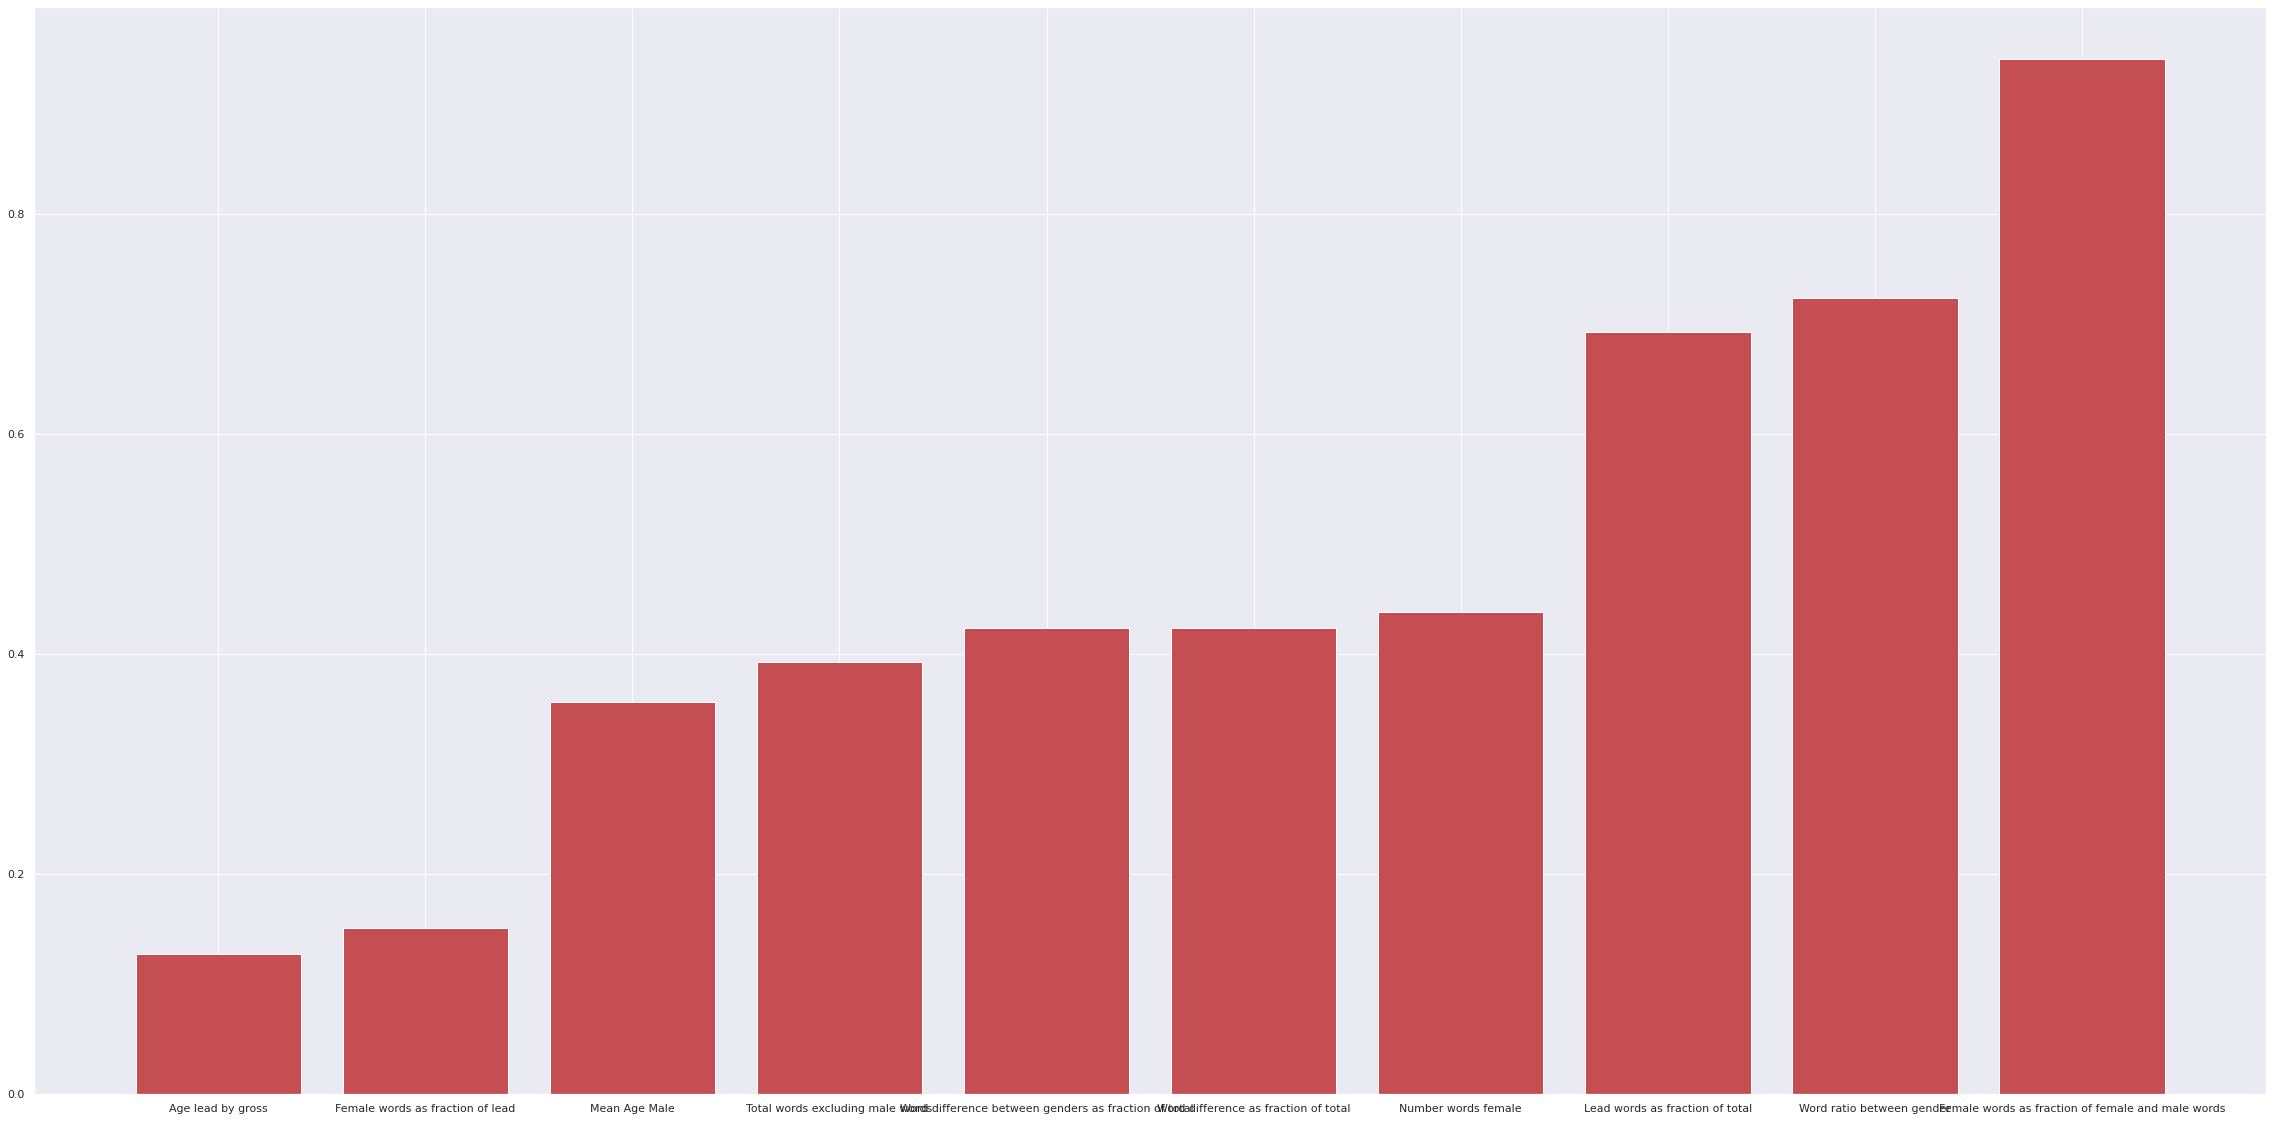

In [ ]:
# Now plot
plt.figure(figsize=(40,20))
plt.bar(bad_features, fit.scores_[indices[range(-1,-11,-1)]], color='r', align='center')
plt.show()

In [ ]:
new_data

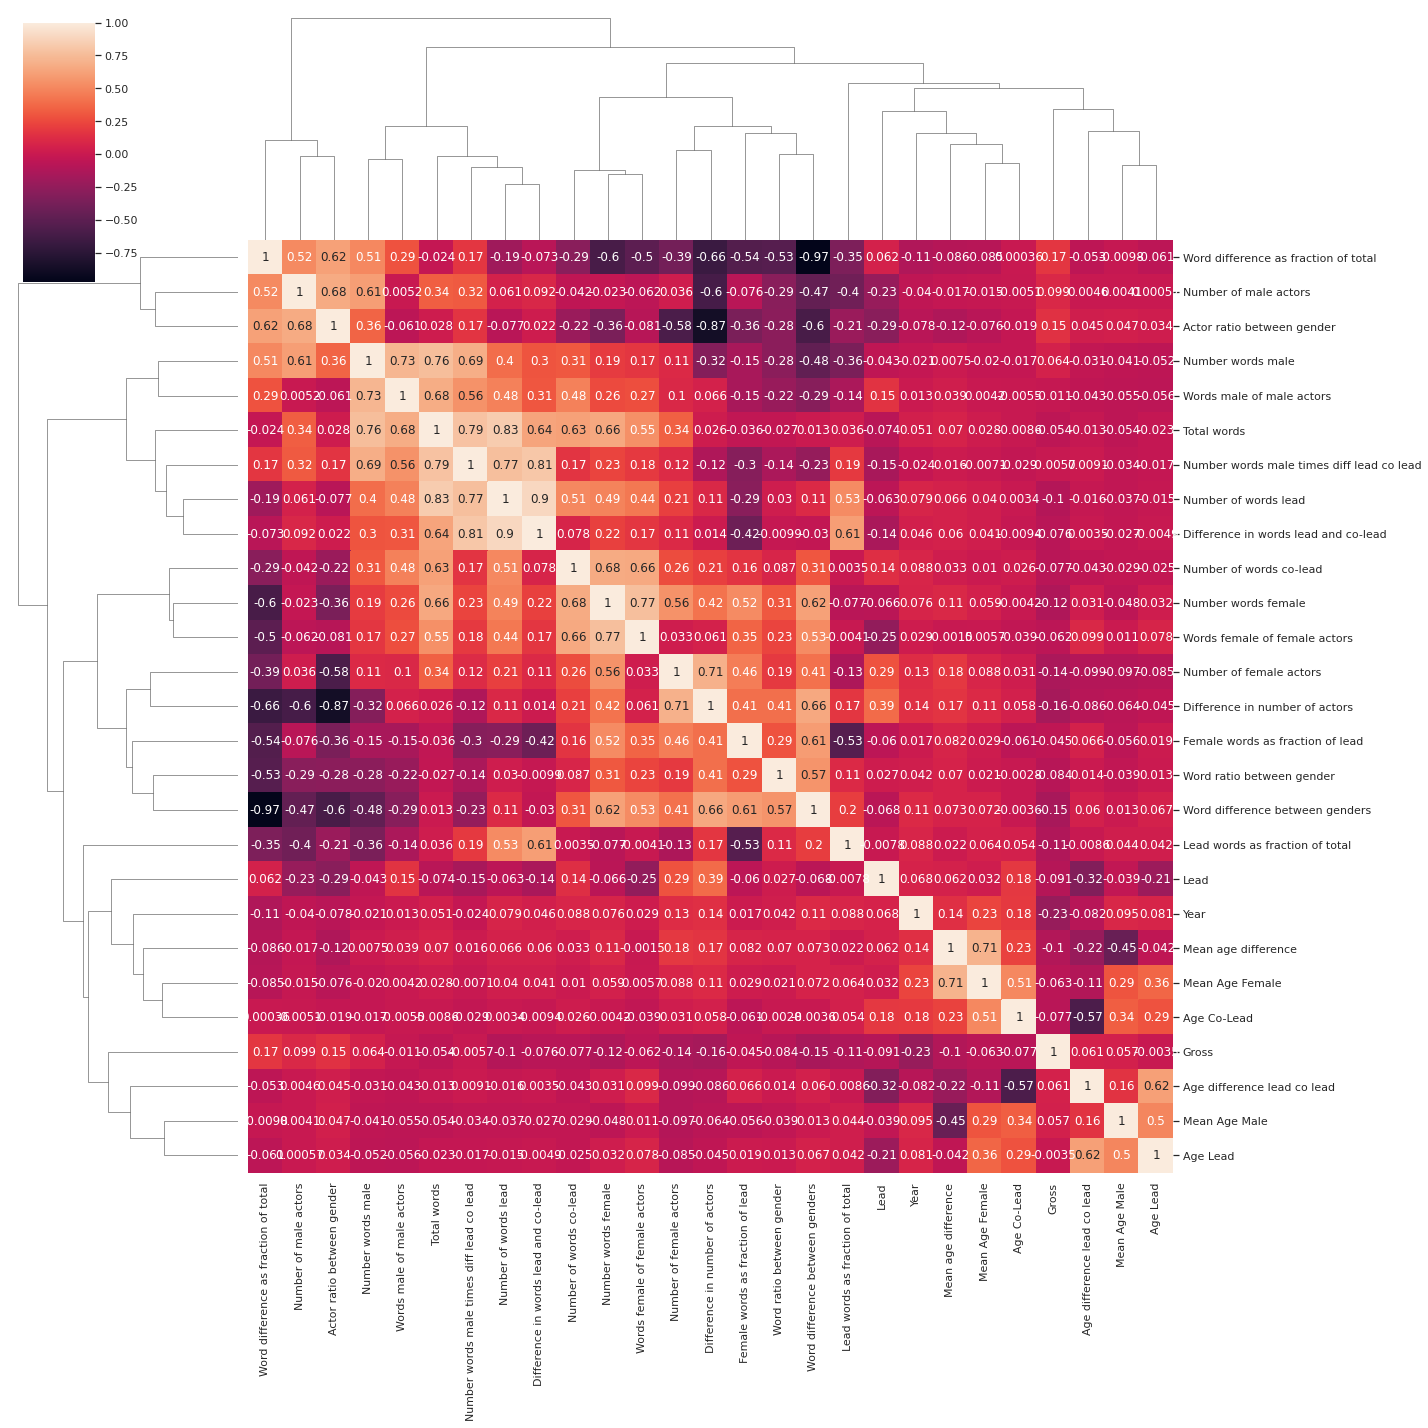

In [ ]:
cor = new_data.corr()
sns.clustermap(cor, annot=cor, figsize = (20,20))

In [ ]:
#HYPERPARAMETER TUNING#

##QDA##
reg_param = np.logspace(-4, 4, 20)
store_covariance = [True, False]

randomgrid_QDA ={'reg_param': reg_param, 'store_covariance': store_covariance}

model = skl_da.QuadraticDiscriminantAnalysis()
rf_random = skl_ms.GridSearchCV(estimator=model , param_grid=randomgrid_QDA,
                                cv=10, verbose =1)
rf_random.fit(X_train_norm[features] , y_train)

In [ ]:
print(f'Best set of hyperparameters are: {rf_random.best_params_}')

Best set of hyperparameters are: {'reg_param': 0.0018329807108324356, 'store_covariance': True}


In [ ]:
model = skl_da.QuadraticDiscriminantAnalysis(reg_param = rf_random.best_params_['reg_param'], store_covariance = rf_random.best_params_['store_covariance'])
model.fit(X_train_norm[features],y_train)
prediction = model.predict(X_test_norm[features])
print(classification_report(y_true=y_test , y_pred=prediction ))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87       201
           1       0.56      0.81      0.67        59

    accuracy                           0.82       260
   macro avg       0.75      0.81      0.77       260
weighted avg       0.85      0.82      0.83       260



In [ ]:
custom_set = ['Age difference, lead and co-lead',
  'Mean age difference',
  'Word difference between genders',
  'Word difference as fraction of total',
  'Difference in number of actors',
  'Lead words as fraction of total',
  'Number of words co-lead',
  'Difference in words lead and co-lead',
  'Female words as fraction of lead',
  'Mean Age Male', # Default feature
 ]

custom_efs_set = ['Number of female actors',
                   'Number of male actors',
                   'Words female of female actors',
                   'Difference in words lead and co-lead',
                   'Words male of male actors',
                   'Number of words co-lead'
                   ]

In [ ]:
custom_efs_set

['Number of female actors',
 'Number of male actors',
 'Words female of female actors',
 'Difference in words lead and co-lead',
 'Words male of male actors',
 'Number of words co-lead']

In [ ]:
model = skl_da.QuadraticDiscriminantAnalysis(reg_param = rf_random.best_params_['reg_param'], store_covariance = rf_random.best_params_['store_covariance'])
model.fit(X_train_norm[custom_set],y_train)
prediction = model.predict(X_test_norm[custom_set])
print(classification_report(y_true=y_test , y_pred=prediction ))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       201
           1       0.59      0.68      0.63        59

    accuracy                           0.82       260
   macro avg       0.74      0.77      0.76       260
weighted avg       0.83      0.82      0.82       260



In [ ]:
import warnings
warnings.filterwarnings("ignore")
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

#EXHAUSTIVE FEATURE SELECTION (BEST?!?)
from mlxtend.feature_selection import ExhaustiveFeatureSelector
#import the algorithm
#from sklearn.ensemble import RandomForestClassifier

#create the ExhaustiveFeatureSelector object
efs = ExhaustiveFeatureSelector(skl_da.QuadraticDiscriminantAnalysis(reg_param=0.615848211066026, store_covariance = True),
                                  min_features=5,
                                  max_features=12,
                                  scoring='accuracy',
                                  print_progress=True,
                                  cv=2)

#fit the object to the training data
efs = efs.fit(new_data.drop(columns=['Lead']),new_data['Lead'])

Features: 62322/62322

In [ ]:
#Print the selected features
selected_features = X_train_norm.columns[list(efs.best_idx_)]
print(selected_features)

#print the final prediction score.
print(efs.best_score_)

Index(['Number words female', 'Total words', 'Number of words lead',
       'Difference in words lead and co-lead', 'Year',
       'Number of female actors', 'Number words male', 'Gross',
       'Age difference, lead and co-lead', 'Words female of female actors'],
      dtype='object')
0.8511007843912728


In [ ]:
custom_features = []
for i in range(len(efs.best_feature_names_)):
  custom_features.append(efs.best_feature_names_[i])


In [ ]:
#HYPERPARAMETER TUNING with custom features#

##QDA##
reg_param = np.logspace(-4, 4, 20)
store_covariance = [True, False]

randomgrid_QDA ={'reg_param': reg_param, 'store_covariance': store_covariance}

model = skl_da.QuadraticDiscriminantAnalysis()
rf_random = skl_ms.GridSearchCV(estimator=model , param_grid=randomgrid_QDA,
                                cv=10, verbose =1)
rf_random.fit(X_train_norm[custom_set] , y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10, estimator=QuadraticDiscriminantAnalysis(),
             param_grid={'reg_param': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'store_covariance': [True, False]},
             verbose=1)

In [ ]:
print(f'Best set of hyperparameters are: {rf_random.best_params_}')

Best set of hyperparameters are: {'reg_param': 0.0001, 'store_covariance': True}


In [ ]:
model = skl_da.QuadraticDiscriminantAnalysis(reg_param = rf_random.best_params_['reg_param'], store_covariance = rf_random.best_params_['store_covariance'])
model.fit(X_train_norm[custom_set],y_train)
prediction = model.predict(X_test_norm[custom_set])
print(classification_report(y_true=y_test , y_pred=prediction ))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       201
           1       0.76      0.88      0.82        59

    accuracy                           0.91       260
   macro avg       0.86      0.90      0.88       260
weighted avg       0.92      0.91      0.91       260



In [ ]:
# 2) Additional features created from the default features
QDA_df = data
QDA_df['Age difference, lead and co-lead'] = QDA_df['Age Lead'] - QDA_df['Age Co-Lead']
QDA_df['Female words as fraction of female and male words'] = QDA_df['Number words female'] / (QDA_df['Number words male'] + QDA_df['Number words female'])
QDA_df['Word difference between genders as fraction of total'] = (QDA_df['Number words male'] - QDA_df['Number words female']) / QDA_df['Total words']
QDA_df['Number of female actors as fraction of total'] = QDA_df['Number of female actors'] / (QDA_df['Number of male actors'] + QDA_df['Number of female actors'])
QDA_df['Lead words as fraction of lead and co-lead'] = QDA_df['Number of words lead'] / (2 * QDA_df['Number of words lead'] - QDA_df['Difference in words lead and co-lead'])
QDA_df['Co-Lead words as fraction of total'] = (QDA_df['Number of words lead'] - QDA_df['Difference in words lead and co-lead']) / QDA_df['Total words']
QDA_df['Mean age female as fraction of total mean age'] = (QDA_df['Mean Age Female']) / (QDA_df['Mean Age Male'] + QDA_df['Mean Age Female'])
QDA_df['Total words excluding male words'] = (QDA_df['Number words female'] + (2 * QDA_df['Number of words lead'] - QDA_df['Difference in words lead and co-lead']))
# 3) Five-fold Cross-Validation
X = QDA_df[['Age difference, lead and co-lead',
  'Female words as fraction of female and male words',
  'Word difference between genders as fraction of total',
  'Number of female actors as fraction of total',
  'Lead words as fraction of lead and co-lead',
  'Co-Lead words as fraction of total',
  'Mean age female as fraction of total mean age',
  'Total words excluding male words',
  'Mean Age Male', # Default feature
  'Number of female actors',
 ]]
y = QDA_df['Lead']


#folds = 5
#random_states = np.arange(200)
#all_mean_accuracies = []
#for state in random_states:
# accuracy = []
# cv = skl_ms.KFold(n_splits=folds, random_state=state, shuffle=True)
# for train_index, val_index in cv.split(X):
#  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#  y_train, y_val = y.iloc[train_index], y.iloc[val_index]
#  model = skl_da.QuadraticDiscriminantAnalysis(reg_param=0.000001).fit(X_train, y_train)
#  y_prediction = model.predict(X_val)
#  accuracy.append(np.mean(y_prediction == y_val))
# mean_accuracy = np.mean(accuracy)
# all_mean_accuracies.append(np.mean(mean_accuracy))
#print(f"The average accuracy was {round(100*np.mean(all_mean_accuracies), 4)}%.")

for train_index, val_index in cv.split(X):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

model = skl_da.QuadraticDiscriminantAnalysis(reg_param = 0.00001, store_covariance = True)
model.fit(X_train,y_train)
prediction = model.predict(X_val)
print(classification_report(y_true=y_val , y_pred=prediction ))


In [ ]:
QDA_df = data.drop(columns=['Year','Gross','Age Lead','Age Co-Lead','Total words','Mean age difference','Number words female','Number of words lead'])
X = QDA_df.drop(columns=['Lead'])
y = QDA_df['Lead']
for train_index, val_index in cv.split(X):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [ ]:
X_train

,Difference in words lead and co-lead,Number of male actors,Number of female actors,Number words male,Mean Age Male,Mean Age Female,"Age difference, lead and co-lead",Difference in number of actors,Female words as fraction of female and male words,Gross as fraction of year,Mean age female as fraction of total mean age,Total words excluding male words,Word difference between genders as fraction of total,Number of female actors as fraction of total,Lead words as fraction of lead and co-lead,Co-Lead words as fraction of total
0,343,2,5,2631,51.500000,42.333333,-19.0,0.714286,0.364953,0.071178,0.451155,5671.0,0.175008,0.714286,0.541236,0.298405
1,1219,9,4,5236,39.125000,29.333333,24.0,0.307692,0.225444,0.018491,0.428484,4345.0,0.422779,0.307692,0.716058,0.091230
2,787,7,1,3079,42.500000,37.000000,9.0,0.125000,0.047928,0.191057,0.465409,1252.0,0.700192,0.125000,0.858706,0.037117
4,3149,8,4,2536,45.250000,45.000000,-3.0,0.333333,0.341812,0.020121,0.498615,5838.0,0.158559,0.333333,0.848264,0.089230
6,287,6,3,2631,47.000000,24.500000,36.0,0.333333,0.363108,0.135859,0.342657,3595.0,0.212514,0.333333,0.568496,0.169861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,1105,3,1,367,48.666667,33.000000,21.0,0.250000,0.257085,0.097930,0.404082,1486.0,0.139050,0.250000,0.906549,0.073581
1034,1166,5,2,761,43.200000,31.000000,22.0,0.285714,0.284774,0.088191,0.417790,1805.0,0.190992,0.285714,0.888149,0.070058
1035,187,6,2,5820,37.166667,24.000000,-13.0,0.250000,0.097954,0.086345,0.392371,4349.0,0.617325,0.250000,0.525155,0.210019
1036,356,2,3,547,27.500000,27.666667,3.0,0.600000,0.707955,0.026500,0.501511,2724.0,-0.283273,0.600000,0.627325,0.189455


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

#EXHAUSTIVE FEATURE SELECTION (BEST?!?)
from mlxtend.feature_selection import ExhaustiveFeatureSelector
#import the algorithm
#from sklearn.ensemble import RandomForestClassifier

#create the ExhaustiveFeatureSelector object
efs = ExhaustiveFeatureSelector(skl_da.QuadraticDiscriminantAnalysis(reg_param=0.0000001, store_covariance = True),
                                  min_features=9,
                                  max_features=9,
                                  scoring='accuracy',
                                  print_progress=True,
                                  cv=5)

#fit the object to the training data
efs = efs.fit(X_train,y_train)

Features: 11440/11440

In [ ]:
#Print the selected features
selected_features = X_train.columns[list(efs.best_idx_)]
print(selected_features)

#print the final prediction score.
print(efs.best_score_)

Index(['Number of male actors', 'Number words male',
       'Age difference, lead and co-lead', 'Difference in number of actors',
       'Female words as fraction of female and male words',
       'Mean age female as fraction of total mean age',
       'Word difference between genders as fraction of total',
       'Lead words as fraction of lead and co-lead',
       'Co-Lead words as fraction of total'],
      dtype='object')
0.9543539427169756


In [ ]:
features

['Difference in number of actors',
 'Number of female actors as fraction of total',
 'Age difference, lead and co-lead',
 'Lead words as fraction of lead and co-lead',
 'Number of female actors',
 'Actor ratio between gender',
 'Co-Lead words as fraction of total',
 'Words female of female actors',
 'Age lead by year',
 'Age Lead',
 'Age Co-Lead',
 'Age co lead by year',
 'Number of male actors',
 'Difference in words lead and co-lead',
 'Number words male times diff lead co lead',
 'Words male of male actors',
 'Number of words lead',
 'Number of words co-lead']

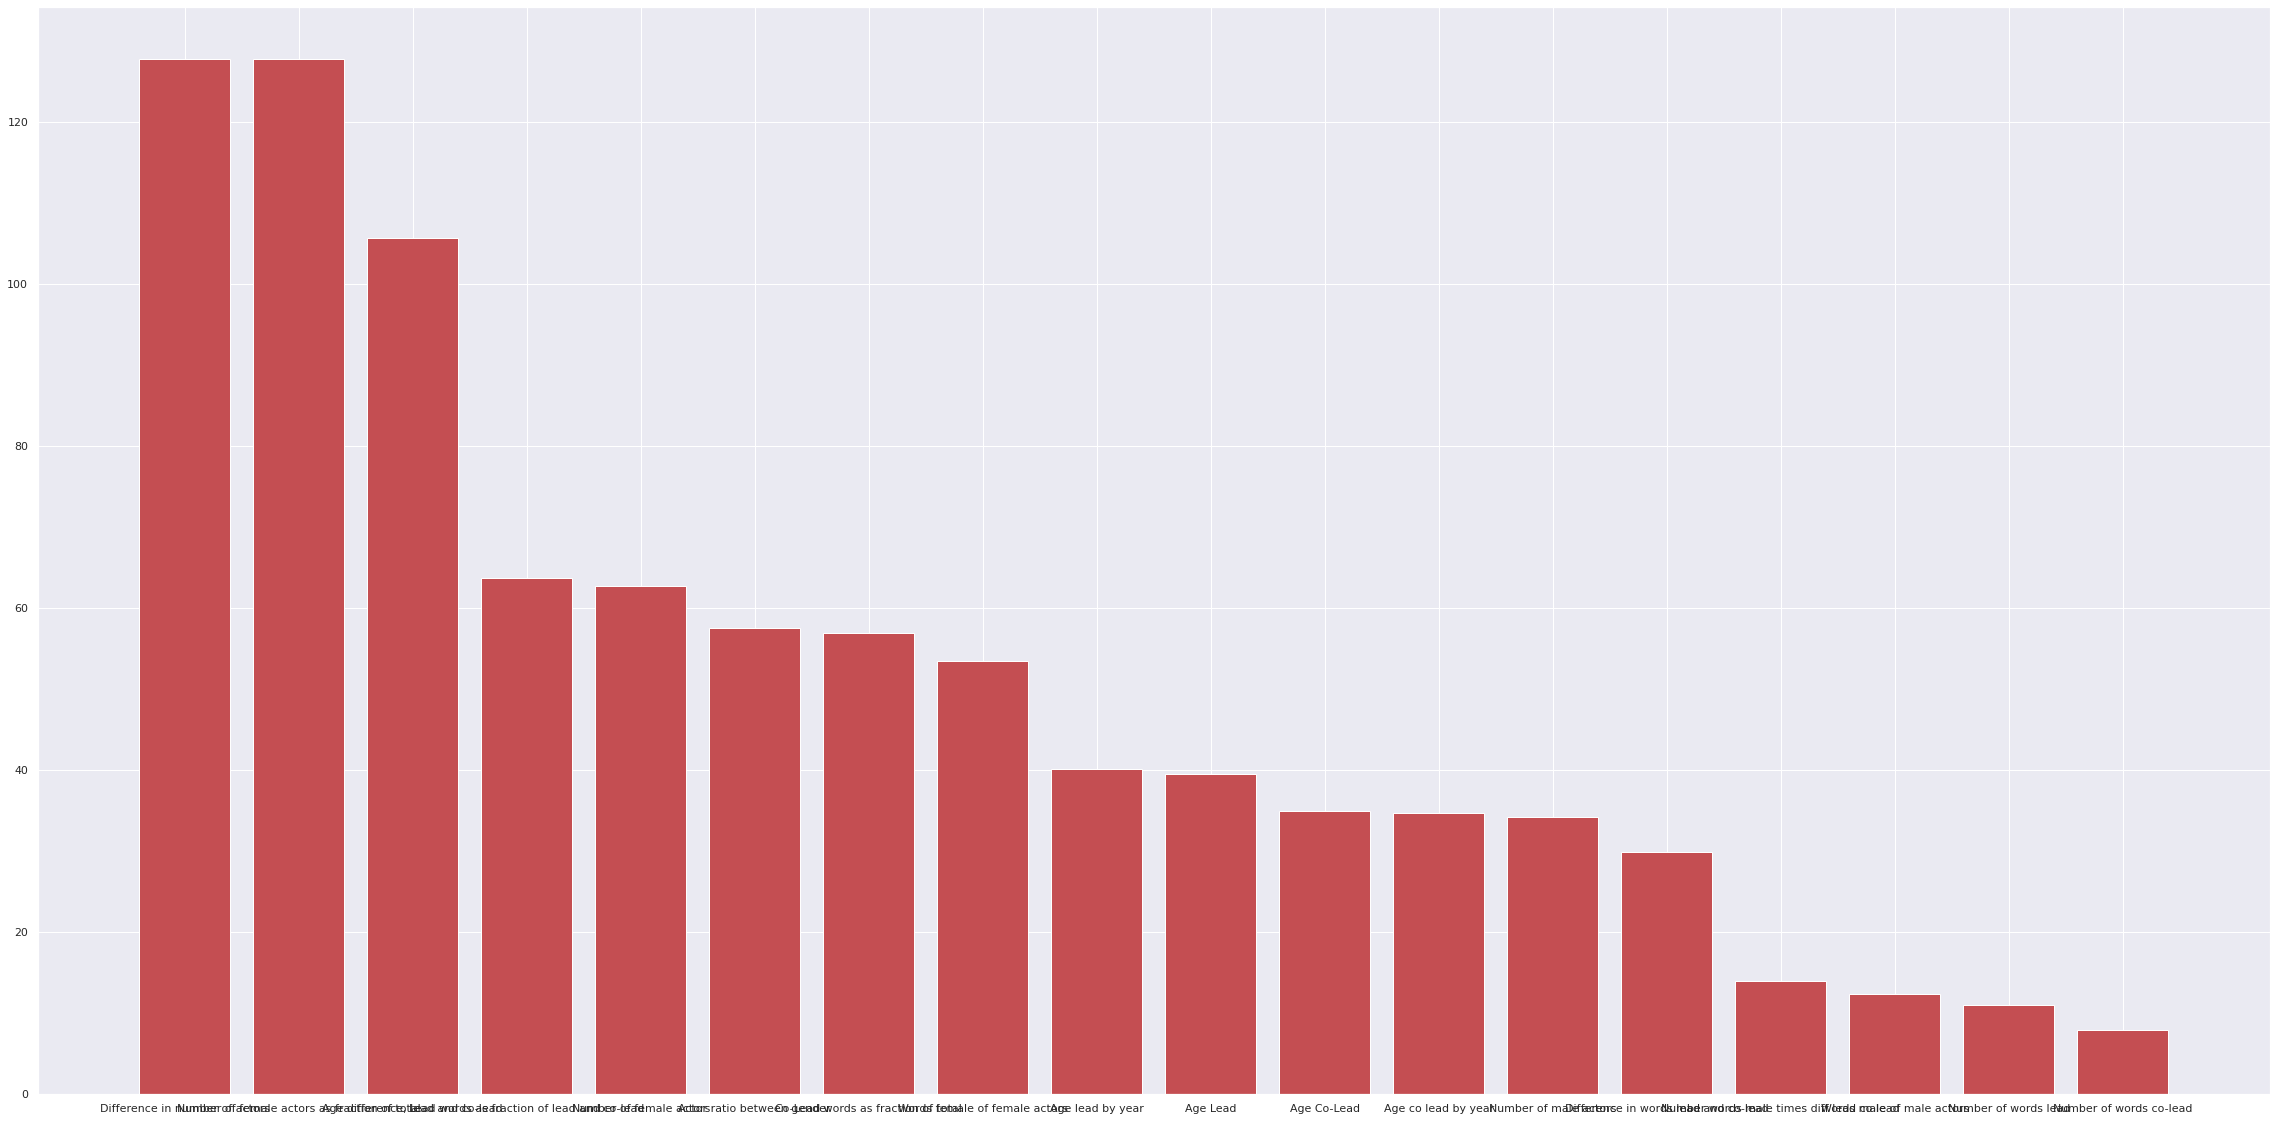

In [ ]:
#Feature selection
number_of_features = 18
y_train = y_train.replace(['Male','Female'] ,[0, 1])
bestfeatures = SelectKBest(score_func=f_classif, k = number_of_features)
fit = bestfeatures.fit(X_train, y_train)

# Get the indices sorted by most important to least important
indices = np.argsort(fit.scores_)[::-1]

# To get your top number_of_features feature names
features = []
for i in range(number_of_features):
    features.append(X_train.columns[indices[i]])

bad_features = []
for i in range(1,15):
    bad_features.append(X_train.columns[indices[-i]])

# Now plot
plt.figure(figsize=(40,20))
plt.bar(features, fit.scores_[indices[range(number_of_features)]], color='r', align='center')
plt.show()

In [ ]:
QDA_df = data
X = QDA_df.drop(columns=['Lead'])
y = QDA_df['Lead']
for train_index, val_index in cv.split(X):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

model = skl_da.QuadraticDiscriminantAnalysis(reg_param = 0.0000001, store_covariance = True)
model.fit(X_train[['Number of male actors', 'Number words male',
       'Age difference, lead and co-lead', 'Difference in number of actors',
       'Female words as fraction of female and male words',
       'Mean age female as fraction of total mean age',
       'Word difference between genders as fraction of total',
       'Lead words as fraction of lead and co-lead',
       'Co-Lead words as fraction of total']],y_train)
prediction = model.predict(X_val[['Number of male actors', 'Number words male',
       'Age difference, lead and co-lead', 'Difference in number of actors',
       'Female words as fraction of female and male words',
       'Mean age female as fraction of total mean age',
       'Word difference between genders as fraction of total',
       'Lead words as fraction of lead and co-lead',
       'Co-Lead words as fraction of total']])
print(classification_report(y_true=y_val , y_pred=prediction ))



              precision    recall  f1-score   support

      Female       0.93      0.84      0.88        49
        Male       0.95      0.98      0.97       158

    accuracy                           0.95       207
   macro avg       0.94      0.91      0.92       207
weighted avg       0.95      0.95      0.95       207

